In [1]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-07-12 12:44:50


In [24]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch.optim.lr_scheduler import ExponentialLR

import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
from scipy.spatial import cKDTree

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle
import gc

from joblib import Parallel, delayed
from tqdm import tqdm
import shutil
import joblib
import pathlib

from metpy.interpolate import interpolate_to_points

from scipy.ndimage import gaussian_filter1d

from data_loader import RTMA_sparse_to_dense_Dataset, Transform
from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedPSNR, MaskedSSIM

import os
import wandb, argparse, sys
from tqdm import tqdm

from data_loader import RTMA_sparse_to_dense_Dataset, Transform, NYSM_sparse_to_dense_Dataset
from models.Google_Unet import GoogleUNet
from models.Deep_CNN import DCNN
from models.UNet import UNet
from models.SwinT2_UNet import SwinT2UNet
from models.util import initialize_weights_xavier,initialize_weights_he

from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss

from sampler import DistributedEvalSampler

from util import str_or_none, int_or_none, bool_from_str, EarlyStopping, save_model_checkpoint, restore_model_checkpoint, init_zarr_store

FIG_DIR = '/home/harish/Dropbox/Apps/Overleaf/AIES_DL_based_Spatial_reconstruction_of_meteorological_variables_measured_by_sparse_stations'
if not os.path.exists(FIG_DIR):
    FIG_DIR = 'Figures'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
from matplotlib.colors import ListedColormap
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = ListedColormap(turbo_colormap_data, name="turbo")

In [5]:
cap_alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
small_alphabets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                  'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Topography, masking, stations, and source data

In [6]:
# === Loading some topography and masking data ===
orography = xr.open_dataset('orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.set_coords(['latitude', 'longitude'])
orography = orography.orog

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values.astype(np.float32))

# Initiate the metrics
metrics = {
    'masked_rmse': MaskedRMSELoss(mask_tensor), 
    'masked_psnr': MaskedPSNR(mask_tensor),
    'masked_ssim': MaskedSSIM(mask_tensor),
}

# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1) # shape: (N, 2)

exclude_indices = [65, 102] # Exclude these indices, since they are falling outside the NYS mask region. 

print(nysm.iloc[[65,102]]['stid'])

# In the previous script, we kept the nysm_latlon and everything intact, without omitting the excluded indices.
# Later on, we conditionally excluded these indices based on the mask.
# Here, we will remove these indices from both nysm_latlon and nysm DataFrame
nysm_latlon = np.delete(nysm_latlon, exclude_indices, axis=0)
nysm = nysm.drop(index=exclude_indices).reset_index(drop=True)  # Drop the excluded indices from the DataFrame

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, RTMA_lat.shape)

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations

ref_zarr_store = 'data/RTMA.zarr'
test_dates_range = ['2023-01-01T00','2023-12-31T23']

# Load RTMA and NYSM once
RTMA_zarr_store = 'data/RTMA.zarr'
RTMA = xr.open_zarr(RTMA_zarr_store)
NYSM = xr.open_dataset('data/NYSM.nc')
NYSM['longitude'] = (NYSM['longitude'] + 360) % 360
NYSM_lat = NYSM.latitude.values
NYSM_lon = NYSM.longitude.values
station_points = np.stack([NYSM_lat.ravel(), NYSM_lon.ravel()], axis=-1)
tree = cKDTree(station_points)
_, station_indices = tree.query(nysm_latlon)
NYSM = NYSM.isel(station=station_indices)
# Now, since both nysm_latlon and NYSM are aligned, we can safely reset the station_indices
station_indices = np.arange(len(nysm_latlon))

print("nysm_latlon shape:", nysm_latlon.shape, "RTMA x_indices shape:", x_indices.shape, "RTMA y_indices shape:", y_indices.shape,"NYSM shape:", NYSM.station.shape)

missing_times = xr.open_dataset(f'nan_times_i10fg.nc').time
freq = 60  # Frequency in minutes, can be changed if needed
# if the additional input variables is not none, add the missing times of the additional input variables also. 
for var in ['si10','t2m','sh2']:
    missing_times = xr.concat([missing_times, xr.open_dataset(f'nan_times_{var}.nc').time], dim='time')
# remove duplicates
missing_times = missing_times.drop_duplicates('time')

65     MANH
102    STAT
Name: stid, dtype: object
nysm_latlon shape: (124, 2) RTMA x_indices shape: (124,) RTMA y_indices shape: (124,) NYSM shape: (124,)


In [7]:
# Create a mapping from original index to sorted index

# --- Sort NYSM stations based on latitude and longitude---
sorted_indices = np.argsort(NYSM['longitude'].values)  # primary: lon, secondary: lat

sorted_indices_map = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(station_indices[sorted_indices])}

## Visualizing NYS mesonet and gust frequency

In [72]:
# Compute gust frequencies
# https://www.weather.gov/mlb/wind_threat

NYSM_resampled = NYSM['i10fg'].sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59'))

# Based on the original RTMA paper, https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://ams.confex.com/ams/pdfpapers/152738.pdf&ved=2ahUKEwiBlL7i9fuNAxVIF1kFHXEwOXYQFnoECB0QAQ&usg=AOvVaw0OpFvCmMcUabt6D9HrfNo
# +-12 minutes is taken as the rolling window for gust frequency calculation
# Since the NYSM data is at 5 minutes frequency, we can use a rolling wind of 5 to cover -10 to +10 minutes around the gust time.

NYSM_resampled = NYSM_resampled.rolling(time=5, min_periods = 1, center=True).max()
NYSM_resampled = NYSM_resampled.sel(time=NYSM_resampled.time.dt.minute==0)

# Compute gust frequencies
gust_threshold = 17.5 #25.7  # m/s
gust_freq_nysm = (
    (NYSM_resampled 
     >= gust_threshold)
    .sum(dim='time')
)

gust_freq_rtma = (RTMA.i10fg.sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59'))
                   >= gust_threshold).sum(dim='time').values[y_indices, x_indices]

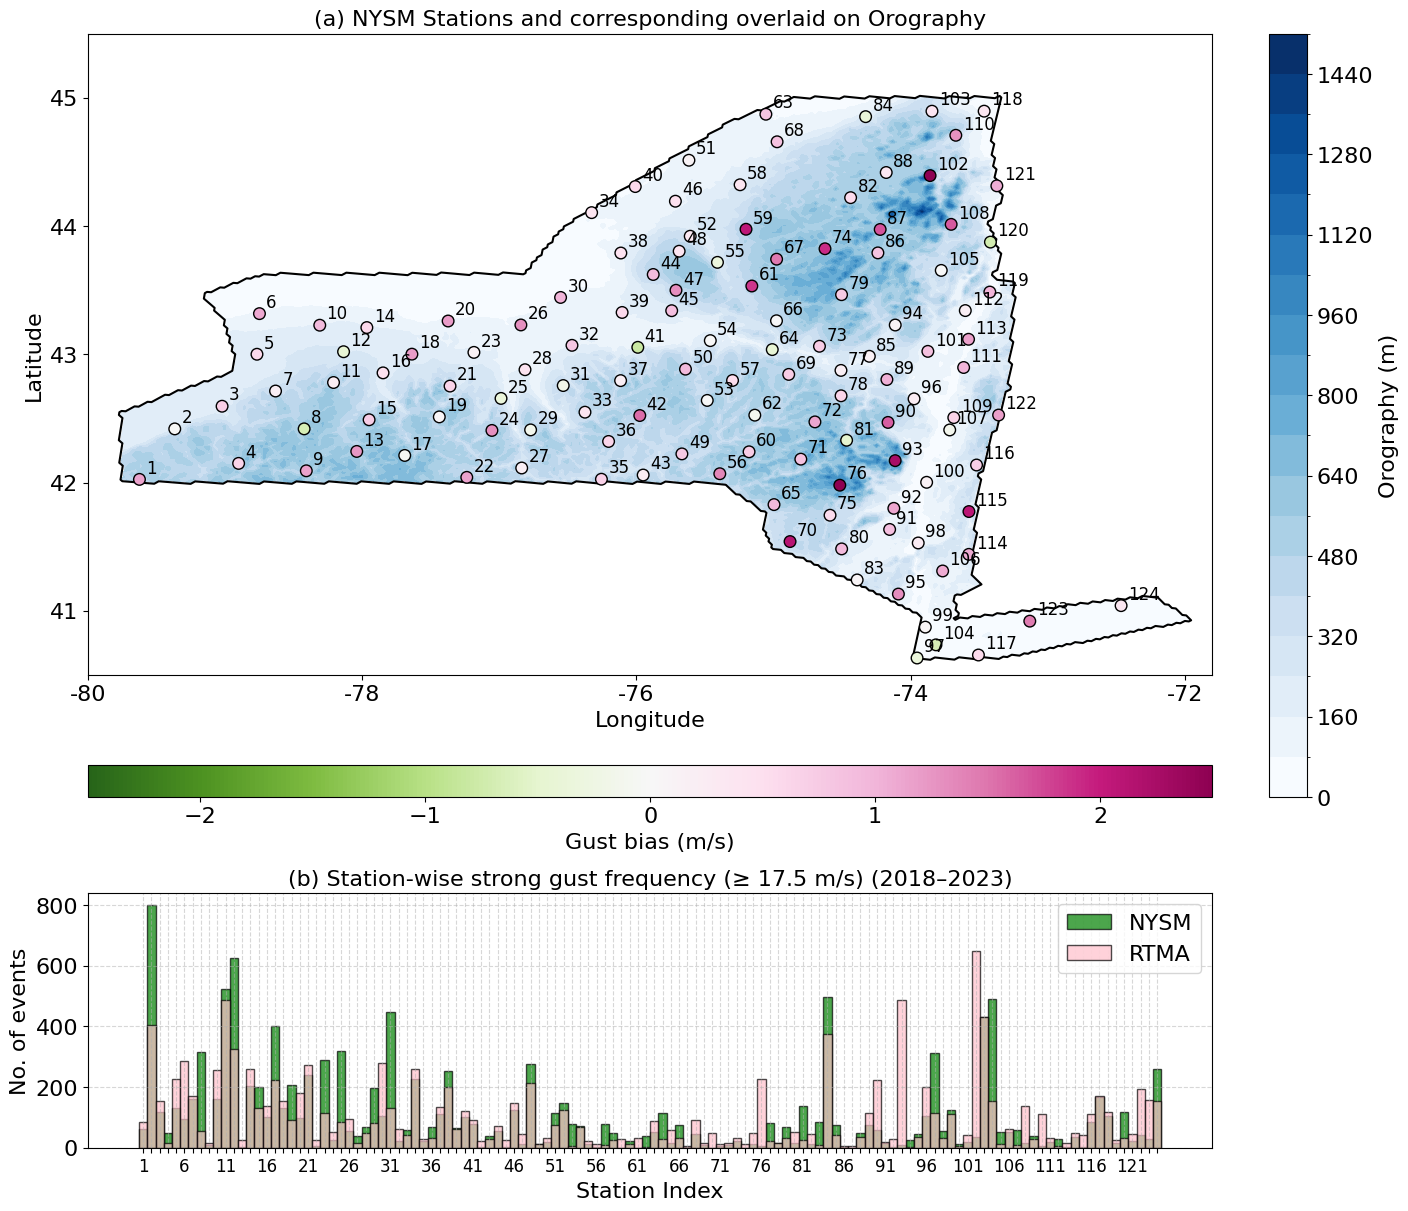

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fontsize = 16

# Extract coordinates and values
lon = NYSM['longitude'].values
lat = NYSM['latitude'].values


lat_sorted = lat[sorted_indices]
lon_sorted = lon[sorted_indices]

# Set up 1x2 subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True,gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})

# === Add domain outline using the mask ===
outline = mask.plot.contour(
    ax=axes[0],
    x='longitude',
    y='latitude',
    colors='black',
    linewidths=1.5,
    levels=[0.5],  # level between 0 and 1 to get the boundary
    add_colorbar=False
)

# === Plot 1: Orography + Station Locations + Indices ===
contour = orography.where(mask).plot.contourf(
    ax=axes[0],
    x='longitude',
    y='latitude',
    levels=20,
    cmap='Blues',
    add_colorbar=True
)
# Set plot limits
axes[0].set_xlim(280, 288.2)
axes[0].set_ylim(40.5, 45.5)
# Set custom tick labels on the same positions
xticks = np.arange(280, 290, 2)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([f"{x - 360 if x > 180 else x}" for x in xticks])
contour.colorbar.set_label('Orography (m)', fontsize=fontsize)
contour.colorbar.ax.tick_params(labelsize=fontsize)

# === Scatter plot for NYSM stations with bias as color ===
gust_bias = RTMA.i10fg.sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59')).mean(dim='time').values[y_indices, x_indices] - NYSM_resampled.mean(dim='time').values 
# Sort gust_bias, gust_freq_nysm, gust_freq_rtma using same order
gust_bias_sorted = gust_bias[sorted_indices]

cmap_bias = 'PiYG_r'
norm_bias = TwoSlopeNorm(vmin=-2.5, vcenter=0, vmax=2.5)
sc2 = axes[0].scatter(
    lon_sorted,
    lat_sorted,
    c=gust_bias_sorted,
    cmap=cmap_bias,
    norm=norm_bias,
    edgecolor='black',
    s=70,
    zorder = 3
)
divider2 = make_axes_locatable(axes[0])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.9)
cb2 = fig.colorbar(sc2, cax=cax2, orientation='horizontal')
cb2.set_label('Gust bias (m/s)', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize)

for i, (x, y) in enumerate(zip(lon_sorted, lat_sorted)):
    axes[0].text(x + 0.05, y + 0.05, str(i+1), fontsize=12, color='black', zorder=4)

axes[0].set_title(f'({small_alphabets[0]}) NYSM Stations and corresponding overlaid on Orography', fontsize=fontsize)
axes[0].set_xlabel('Longitude', fontsize=fontsize)
axes[0].set_ylabel('Latitude', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)

# === Plot 2: Bar plot of gust frequency ===
gust_freq_nysm_sorted = gust_freq_nysm.values[sorted_indices]
gust_freq_rtma_sorted = gust_freq_rtma[sorted_indices]

station_indices_sorted = np.arange(len(lat_sorted))
axes[1].bar(station_indices_sorted, gust_freq_nysm_sorted, width=1, label='NYSM', color='green', edgecolor='black', alpha=0.7)
axes[1].bar(station_indices_sorted, gust_freq_rtma_sorted, width=1, label='RTMA', color='pink', edgecolor='black', alpha=0.7)

axes[1].set_xlabel('Station Index', fontsize=fontsize)
axes[1].set_ylabel('No. of events', fontsize=fontsize)
axes[1].set_title(f'({small_alphabets[1]}) Station-wise strong gust frequency (≥ 17.5 m/s) (2018–2023)', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)
axes[1].set_xticks(station_indices_sorted)
# Show labels only at every 5th index, hide others by setting them as empty strings
xtick_labels = [str(i+1) if i % 5 == 0 else '' for i in station_indices_sorted]
axes[1].set_xticklabels(xtick_labels, fontsize=12)
axes[1].legend(fontsize=fontsize)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.savefig(os.path.join(FIG_DIR, 'gust_frequency.png'), dpi=300)

# Visualizing the ramdom stations

In [8]:
from sklearn.neighbors import BallTree

def get_distances(lat_lon: np.ndarray, k: int):
    # Convert degrees to radians
    lat_lon_rad = np.radians(lat_lon)
    
    # Use haversine metric in BallTree
    tree = BallTree(lat_lon_rad, metric='haversine')
    dist, _ = tree.query(lat_lon_rad, k=k + 1)
    dist = dist[:, 1:]  # Exclude self-distance

    # Convert radians to km (Earth radius = 6371 km)
    dist_km = dist * 6371

    return dist_km

In [9]:
"""
The stations (original) have been saved by name, which itself is pretty much random.
Thus, either we could leave the order as it, and divide them into four groups wich 31 stations in each.
Or, we could randomize them and divide into four groups of 31 stations each, such that the groups represent similar mean distance. 
"""

'\nThe stations (original) have been saved by name, which itself is pretty much random.\nThus, either we could leave the order as it, and divide them into four groups wich 31 stations in each.\nOr, we could randomize them and divide into four groups of 31 stations each, such that the groups represent similar mean distance. \n'

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

def make_four_diverse_groups(latlon: np.ndarray, total_groups: int = 4, subset_size: int = 31, random_state: int = 42):
    assert total_groups * subset_size <= latlon.shape[0], "Not enough stations to divide."

    # Step 1: Fine-grain KMeans to get 124 micro-clusters
    n_clusters = total_groups * subset_size
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(latlon)
    centers = kmeans.cluster_centers_

    # Step 2: From each cluster, select closest station to its center
    representatives = []
    for cluster_id in range(n_clusters):
        idxs = np.where(labels == cluster_id)[0]
        if len(idxs) == 0:
            continue  # Shouldn’t happen but safe check
        elif len(idxs) == 1:
            representatives.append(idxs[0])
        else:
            closest_idx = idxs[
                pairwise_distances_argmin(centers[cluster_id][None, :], latlon[idxs])
            ][0]
            representatives.append(closest_idx)

    # Step 3: Shuffle and split into 4 groups of 31
    representatives = np.array(representatives)
    np.random.seed(random_state)
    np.random.shuffle(representatives)
    groups = [representatives[i * subset_size: (i + 1) * subset_size] for i in range(total_groups)]

    return groups


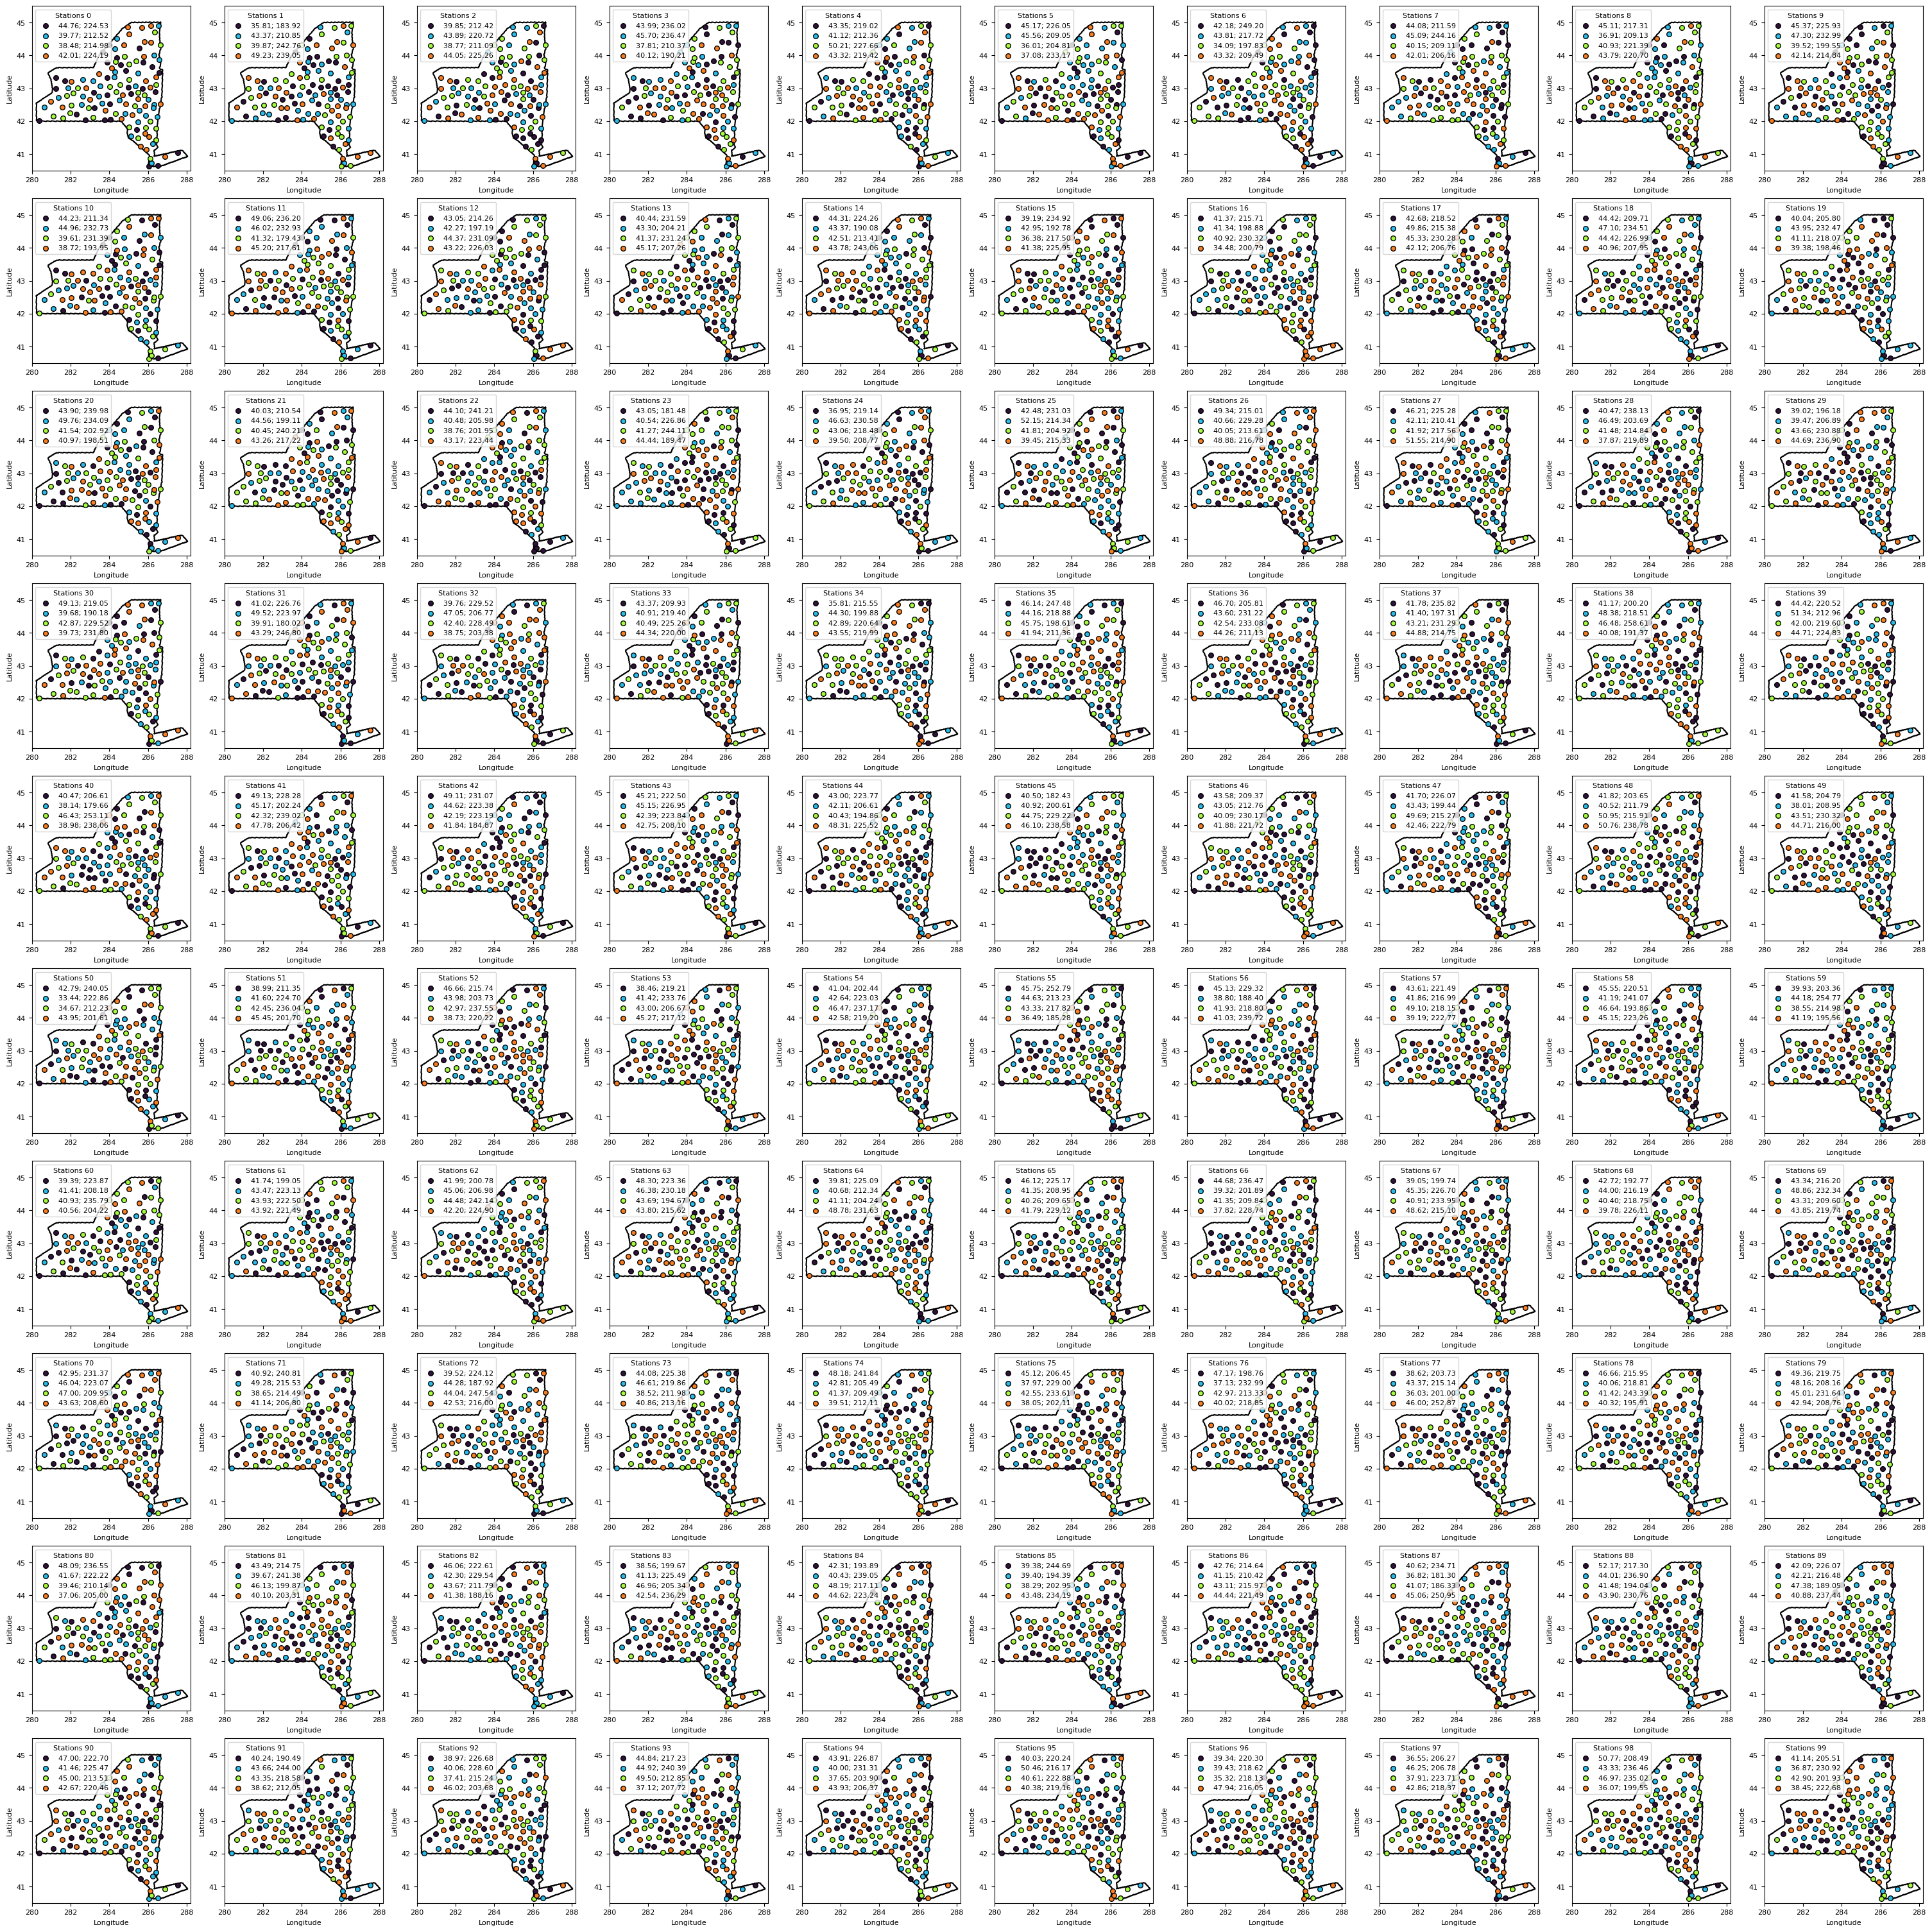

In [ ]:
# Set up 1x2 subplots
fig, axes = plt.subplots(10, 10, figsize=(30, 30), constrained_layout=True)
fontsize = 8

for random_state in np.arange(0,100):
    selected_groups = make_four_diverse_groups(nysm_latlon,random_state=random_state)

    ax = axes[random_state // 10, random_state % 10]

    mask.plot.contour(
    ax=ax,
    x='longitude',
    y='latitude',
    colors='black',
    linewidths=1.5,
    levels=[0.5],  # level between 0 and 1 to get the boundary
    add_colorbar=False
    )

    # First group stations
    for group_idx, group in enumerate(selected_groups):
        dist1 = get_distances(nysm_latlon[group], k=1)
        dist2 = get_distances(nysm_latlon[group], k=30)
        ax.scatter(
            NYSM['longitude'].values[group],
            NYSM['latitude'].values[group],
            edgecolor='black',
            c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
            label=f'{np.mean(dist1):.2f}; {np.mean(dist2):.2f}',
            s=30,
            zorder = 3
        )   

    # Set plot limits
    ax.set_xlim(280, 288.2)
    ax.set_ylim(40.5, 45.5)
    ax.set_xlabel('Longitude', fontsize=fontsize)
    ax.set_ylabel('Latitude', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

    ax.legend(title=f'Stations {random_state}', fontsize=fontsize, title_fontsize=fontsize)

plt.savefig(os.path.join(FIG_DIR, 'diverse_groups.pdf'), dpi=300)

- From the figure, we find groups from random_state = 4 were much dispersed

In [43]:
random_state = 4
selected_groups = make_four_diverse_groups(nysm_latlon,random_state=random_state)

with open("selected_groups.pkl", "wb") as f:
    pickle.dump(selected_groups, f)

In [44]:
with open("selected_groups.pkl", "rb") as f:
    selected_groups = pickle.load(f)

In [47]:
selected_groups

[array([ 21,  99,  32,  26,   9,  80, 103,  70,  10,   1,  82,  55,  49,
         14,  66,  93,  27,  33,  54,  23,  65,  77,  76,  35,  28,   7,
         57,  12,  19, 110, 116]),
 array([107,  47,  83, 115,  15,  97,  68,  81, 100,  98,  38,  25,  64,
         36,  52,  74, 117,  18,  67,  71,  48,  59, 120,  75,  84,  41,
         24,  96,  94,  88,  37]),
 array([ 40,   4, 123,  62,  20,  46,  85, 118,  78,  11,  58,  42,  87,
         73,  95,   2,   6, 114,  39, 111, 105,   0,  44, 102,  92,  86,
         53,  51,  34,  61, 122]),
 array([104,  43, 101, 108, 121,  91, 119,  16,  79,  56,  30,  29,  60,
         69, 113,  63,  13, 109,   3,  90,  89, 106,   5,   8,  72,  45,
         17,  22, 112,  50,  31])]

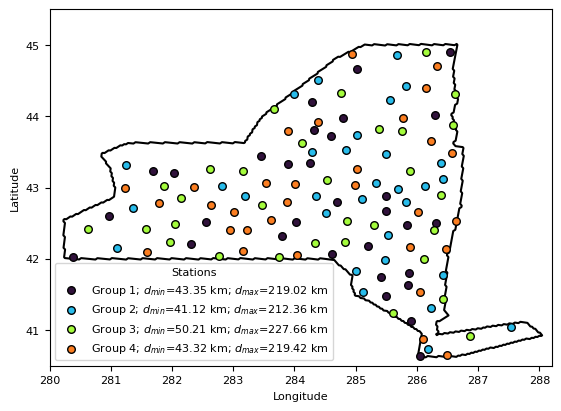

In [ ]:
# Set up 1x2 subplots
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), constrained_layout=True)
fontsize = 8

mask.plot.contour(
ax=ax,
x='longitude',
y='latitude',
colors='black',
linewidths=1.5,
levels=[0.5],  # level between 0 and 1 to get the boundary
add_colorbar=False
)

# First group stations
for group_idx, group in enumerate(selected_groups):
    dist1 = get_distances(nysm_latlon[group], k=1)
    dist2 = get_distances(nysm_latlon[group], k=30)
    ax.scatter(
        NYSM['longitude'].values[group],
        NYSM['latitude'].values[group],
        edgecolor='black',
        c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
        label=fr'Group {group_idx+1}; $d_{{min}}$={np.mean(dist1):.2f} km; $d_{{max}}$={np.mean(dist2):.2f} km',
        s=30,
        zorder = 3
    )   

# Set plot limits
ax.set_xlim(280, 288.2)
ax.set_ylim(40.5, 45.5)
ax.set_xlabel('Longitude', fontsize=fontsize)
ax.set_ylabel('Latitude', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

ax.legend(title=f'Stations', fontsize=fontsize, title_fontsize=fontsize)

#plt.savefig(os.path.join(FIG_DIR, 'diverse_groups.pdf'), dpi=300)

In [ ]:
"""
inference_stations_list = {}
n_infer_93 = {}
n_infer_93['fold_0'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1,2]]), 'test':selected_groups[3]}
n_infer_93['fold_1'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1,3]]), 'test':selected_groups[2]}
n_infer_93['fold_2'] = {'inference':np.concatenate([selected_groups[j] for j in [0,2,3]]), 'test':selected_groups[1]}
n_infer_93['fold_3'] = {'inference':np.concatenate([selected_groups[j] for j in [1,2,3]]), 'test':selected_groups[0]}

inference_stations_list['n_infer_93'] = n_infer_93

n_infer_62 = {}
n_infer_62['fold_0'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1]]), 'test':np.concatenate([selected_groups[j] for j in [2,3]])}
n_infer_62['fold_1'] = {'inference':np.concatenate([selected_groups[j] for j in [0,3]]), 'test':np.concatenate([selected_groups[j] for j in [1,2]])}
n_infer_62['fold_2'] = {'inference':np.concatenate([selected_groups[j] for j in [2,3]]), 'test':np.concatenate([selected_groups[j] for j in [0,1]])}
n_infer_62['fold_3'] = {'inference':np.concatenate([selected_groups[j] for j in [1,2]]), 'test':np.concatenate([selected_groups[j] for j in [0,3]])}
n_infer_62['fold_4'] = {'inference':np.concatenate([selected_groups[j] for j in [0,2]]), 'test':np.concatenate([selected_groups[j] for j in [1,3]])}
n_infer_62['fold_5'] = {'inference':np.concatenate([selected_groups[j] for j in [1,3]]), 'test':np.concatenate([selected_groups[j] for j in [0,2]])}

inference_stations_list['n_infer_62'] = n_infer_62

# Save the inference stations list to pickle file
import pickle
with open('inference_stations_list.pkl', 'wb') as f:
    pickle.dump(inference_stations_list, f)
"""

In [14]:
with open(f"inference_stations_list.pkl", "rb") as f:
    inference_stations_list = pickle.load(f)

n_inference_stations,fold = 93,0
inference_stations_list[f'n_infer_{n_inference_stations}'][f'fold_{fold}']['inference']

array([ 21,  99,  32,  26,   9,  80, 103,  70,  10,   1,  82,  55,  49,
        14,  66,  93,  27,  33,  54,  23,  65,  77,  76,  35,  28,   7,
        57,  12,  19, 110, 116, 107,  47,  83, 115,  15,  97,  68,  81,
       100,  98,  38,  25,  64,  36,  52,  74, 117,  18,  67,  71,  48,
        59, 120,  75,  84,  41,  24,  96,  94,  88,  37,  40,   4, 123,
        62,  20,  46,  85, 118,  78,  11,  58,  42,  87,  73,  95,   2,
         6, 114,  39, 111, 105,   0,  44, 102,  92,  86,  53,  51,  34,
        61, 122])

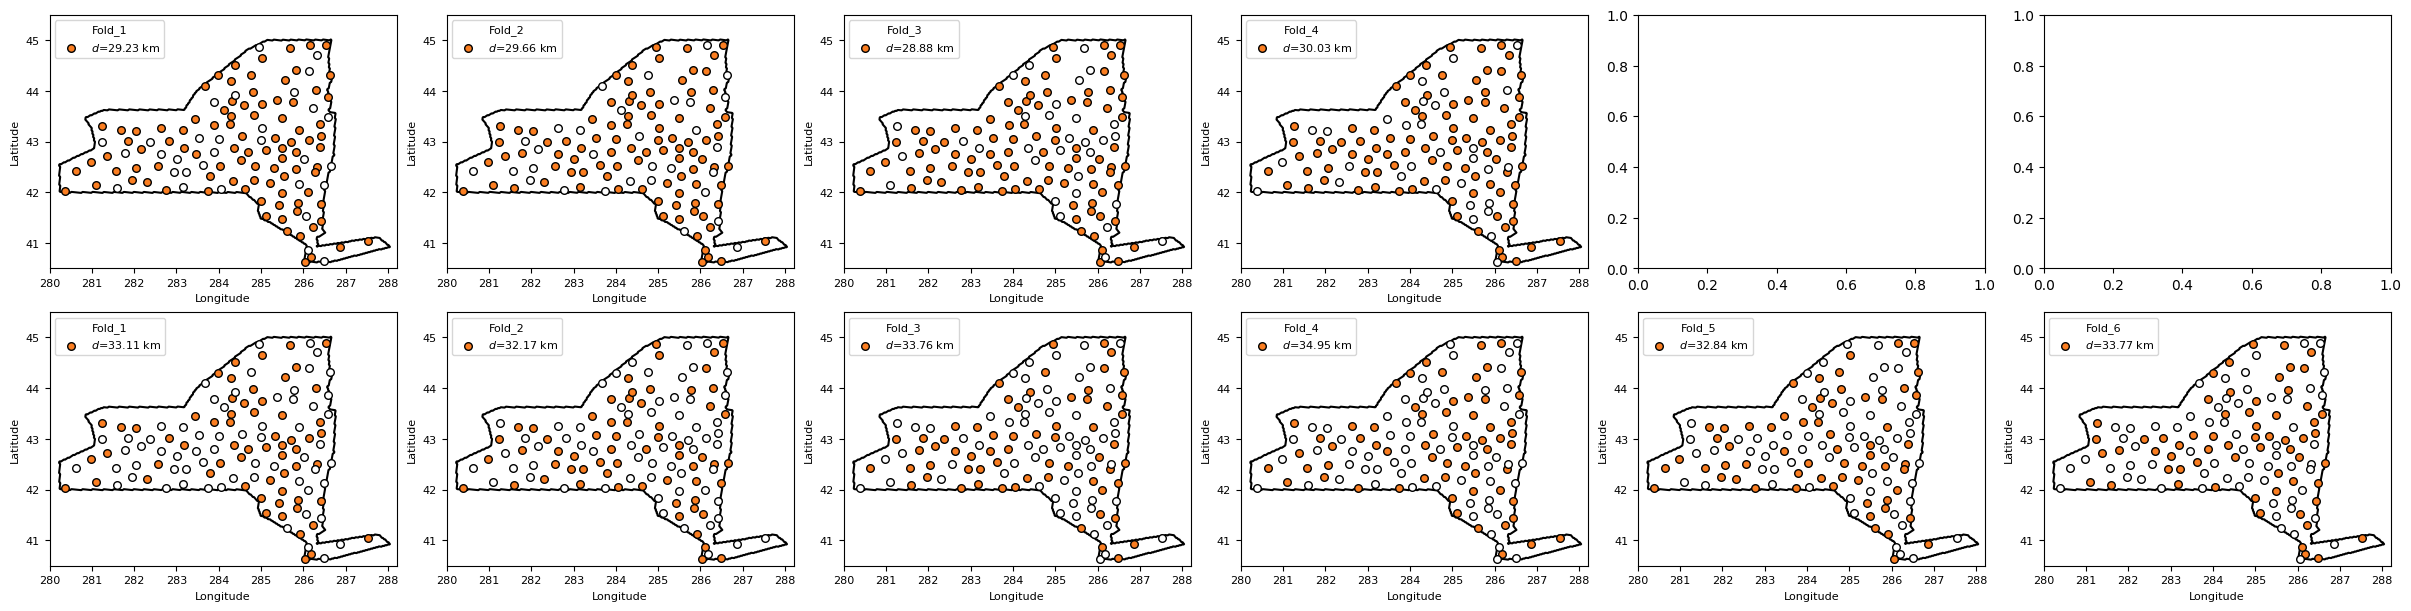

In [15]:
# Set up 1x2 subplots
fig, axes = plt.subplots(2, 6, figsize=(24, 6), constrained_layout=True)
fontsize = 8

for i in range(len(inference_stations_list)):
    experiment_name = list(inference_stations_list.keys())[i]
    folds = inference_stations_list[experiment_name]
    for j, (fold_name, split) in enumerate(folds.items()):
        # Plot the stations for this fold
        ax = axes[i, j]
        mask.plot.contour(
        ax=ax,
        x='longitude',
        y='latitude',
        colors='black',
        linewidths=1.5,
        levels=[0.5],  # level between 0 and 1 to get the boundary
        add_colorbar=False
        )
        dist = get_distances(nysm_latlon[split['inference']], k=1)
        ax.scatter(
            NYSM['longitude'].values[split['inference']],
            NYSM['latitude'].values[split['inference']],
            edgecolor='black',
            c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
            label=fr'$d$={np.mean(dist):.2f} km',
            s=30,
            zorder = 3
        )  
        ax.scatter(
            NYSM['longitude'].values[split['test']],
            NYSM['latitude'].values[split['test']],
            edgecolor='black',
            c='white',  
            s=30,
            zorder = 3
        )   
        # Set plot limits
        ax.set_xlim(280, 288.2)
        ax.set_ylim(40.5, 45.5)
        ax.set_xlabel('Longitude', fontsize=fontsize)
        ax.set_ylabel('Latitude', fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)

        ax.legend(title=f'Fold_{j+1}',fontsize=fontsize, title_fontsize=fontsize, loc='upper left')

In [87]:
prediction_dir = 'Predictions'
variable = 'i10fg'

variable = 'i10fg'
model = 'UNet'
stations_seed = 42

percentiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999,1]
colors = ['green', 'red', 'grey', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles

data_type = 'NYSM'

n_inference_stations = 93

folds = [3,2,1,0]

labels = ['Barnes Interp', 'DL_{n_all}', 'DL_{n_100}', 'DL_{n_75}', 'DL_{n_50}']
all_preds = {label: [] for label in labels}  # To store fold-wise predictions
target_data_list = []
for group, fold in zip(selected_groups, folds):
    test_stations = group
    local_y_indices = y_indices[test_stations]
    local_x_indices = x_indices[test_stations]
    local_station_indices = station_indices[test_stations]

    indexers = {
        'y': xr.DataArray(local_y_indices, dims='point'),
        'x': xr.DataArray(local_x_indices, dims='point')
    }

    # === Build paths for all 5 prediction types
    zarr_paths = []

    # 1. Barnes Interpolation
    zarr_paths.append(f"{prediction_dir}/Barnes_interpolated/{n_inference_stations}-inference-stations/fold_{fold}/{data_type}_test.zarr")

    # 2–5. DL predictions for all, 100, 75, 50
    for train_val in ['all', 100, 75, 50]:
        train_dir = f'{stations_seed}/{train_val}-random-stations-per-sample' if train_val != 'all' else 'all-stations'
        zarr_paths.append(
            f'{prediction_dir}/{variable}/{model}/orography-si10-t2m-sh2/2018-2021/{train_dir}/MaskedCharbonnierLoss/standard/gelu-42/{n_inference_stations}-inference-stations/fold_{fold}/{data_type}_test.zarr'
        )

    # === Load and store each prediction for this fold
    for label, path in zip(labels, zarr_paths):
        test_ds = xr.open_zarr(path)[variable].sel(time=slice(*test_dates_range))
        test_data = test_ds.isel(**indexers).transpose('time', 'point')
        all_preds[label].append(test_data)
    
    # Target data either from RTMA or NYSM
    target_ds = NYSM[variable].sel(time=slice(*test_dates_range))
    target_data = target_ds.isel(station=local_station_indices)
    target_data_list.append(target_data)

# === After collecting all folds, concatenate across station dim
for label in labels:
    with ProgressBar():
        all_preds[label] = xr.concat(all_preds[label], dim='point').load()  # now (time, 124)

# === Concatenate all target data along station dim
target_data = xr.concat(target_data_list, dim='station')
with ProgressBar():
    target_data = target_data.T.values

[########################################] | 100% Completed | 24.23 s
[########################################] | 100% Completed | 30.25 s
[########################################] | 100% Completed | 29.23 s
[########################################] | 100% Completed | 8.60 ss
[########################################] | 100% Completed | 8.45 sms


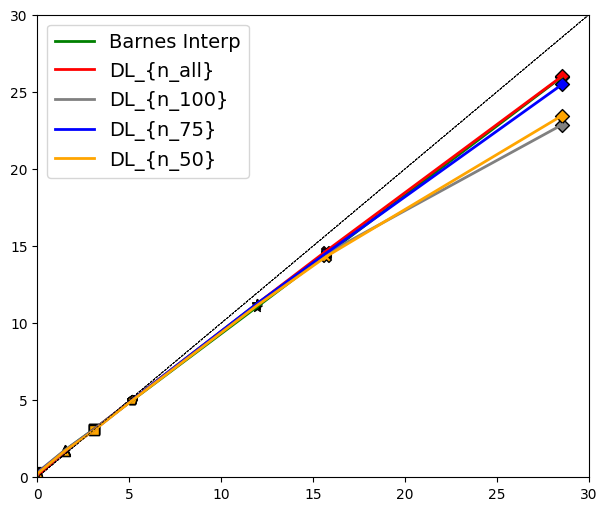

In [93]:
fontsize = 14
fig = plt.figure(figsize=(17, 5), constrained_layout=True)
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0])
for j,(label,test_data) in enumerate(all_preds.items()):

    # Flatten the data for plotting
    test_1d = test_data.values.flatten()
    target_1d = target_data.flatten()

    # Step 2: Create a mask of valid (non-NaN) values across all
    valid_mask = (
        ~np.isnan(test_1d) &
        ~np.isnan(target_1d)
    )
    # Step 3: Apply the mask to all arrays
    test_clean = test_1d[valid_mask]
    target_clean = target_1d[valid_mask]

    # Compute quantiles for 
    x_quantiles = np.quantile(target_clean, percentiles)
    y_quantiles = np.quantile(test_clean, percentiles)

    line, = ax.plot(x_quantiles, y_quantiles, linestyle='-', color=colors[j], label=label, linewidth=2)

    # Add markers for different percentiles
    for l in range(len(percentiles)):
        marker_point = ax.scatter(x_quantiles[l], y_quantiles[l], facecolors=colors[j], marker=markers[l], s=50, edgecolors='black')

    # Set plot limits
    min_value, max_value =0, 30
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add 1:1 reference line
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', linewidth=0.5)
ax.legend(loc='upper left', fontsize=fontsize)

TypeError: list indices must be integers or slices, not tuple

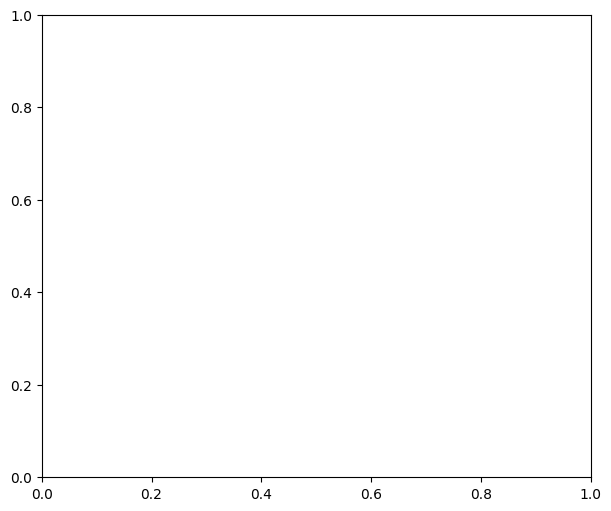

In [ ]:
fontsize = 14
fig = plt.figure(figsize=(17, 5), constrained_layout=True)
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0])
for j,(label,test_data) in enumerate(list(all_preds.items())[0:2]):

    # Flatten the data for plotting
    test_1d = test_data.values.flatten()
    target_1d = target_data.flatten()

    # Step 2: Create a mask of valid (non-NaN) values across all
    valid_mask = (
        ~np.isnan(test_1d) &
        ~np.isnan(target_1d)
    )
    # Step 3: Apply the mask to all arrays
    test_clean = test_1d[valid_mask]
    target_clean = target_1d[valid_mask]

    # Compute quantiles for 
    x_quantiles = np.quantile(target_clean, percentiles)
    y_quantiles = np.quantile(test_clean, percentiles)

    line, = ax.plot(x_quantiles, y_quantiles, linestyle='-', color=colors[j], label=label, linewidth=2)

    # Add markers for different percentiles
    for l in range(len(percentiles)):
        marker_point = ax.scatter(x_quantiles[l], y_quantiles[l], facecolors=colors[j], marker=markers[l], s=50, edgecolors='black')

    # Set plot limits
    min_value, max_value =0, 30
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add 1:1 reference line
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', linewidth=0.5)
ax.legend(loc='upper left', fontsize=fontsize)

In [ ]:
prediction_dir = 'Predictions'
variable = 'i10fg'

variable = 'i10fg'
model = 'UNet'
stations_seed = 42

percentiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999,1]
colors = ['green', 'red', 'grey', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles

data_type = 'NYSM'

n_inference_stations = 62

FOLDS = [[2,3,5],[1,2,4],[0,1,5],[0,3,4]]

labels = ['Barnes Interp', 'DL_{n_{all}}', 'DL_{n_{100}}', 'DL_{n_{75}}', 'DL_{n_{50}}']
all_preds = {label: [] for label in labels}  # To store fold-wise predictions
target_data_list = []
for group, folds in zip(selected_groups, FOLDS):
    test_stations = group
    local_y_indices = y_indices[test_stations]
    local_x_indices = x_indices[test_stations]
    local_station_indices = station_indices[test_stations]

    indexers = {
        'y': xr.DataArray(local_y_indices, dims='point'),
        'x': xr.DataArray(local_x_indices, dims='point')
    }

    # Temporary store for 3 folds
    preds_per_label = {label: [] for label in labels}

    for fold in folds:
        # === Build paths for all 5 prediction types
        zarr_paths = []

        # 1. Barnes Interpolation
        zarr_paths.append(f"{prediction_dir}/Barnes_interpolated/{n_inference_stations}-inference-stations/fold_{fold}/{data_type}_test.zarr")

        # 2–5. DL predictions for all, 100, 75, 50
        for train_val in ['all', 100, 75, 50]:
            train_dir = f'{stations_seed}/{train_val}-random-stations-per-sample' if train_val != 'all' else 'all-stations'
            zarr_paths.append(
                f'{prediction_dir}/{variable}/{model}/orography-si10-t2m-sh2/2018-2021/{train_dir}/MaskedCharbonnierLoss/standard/gelu-42/{n_inference_stations}-inference-stations/fold_{fold}/{data_type}_test.zarr'
            )

        # === Load and store each prediction for this fold
        for label, path in zip(labels, zarr_paths):
            test_ds = xr.open_zarr(path)[variable].sel(time=slice(*test_dates_range))
            test_data = test_ds.isel(**indexers).transpose('time', 'point')
            preds_per_label[label].append(test_data)
        
    # === Average across 3 folds
    for label in labels:
        all_preds[label].append(xr.concat(preds_per_label[label], dim='fold').mean(dim='fold'))
    
    # Target data either from RTMA or NYSM
    target_ds = NYSM[variable].sel(time=slice(*test_dates_range))
    target_data = target_ds.isel(station=local_station_indices)
    target_data_list.append(target_data)

# === After collecting all folds, concatenate across station dim
for label in labels:
    with ProgressBar():
        all_preds[label] = xr.concat(all_preds[label], dim='point').load()  # now (time, 124)

# === Concatenate all target data along station dim
target_data = xr.concat(target_data_list, dim='station')
with ProgressBar():
    target_data = target_data.T.values


[########################################] | 100% Completed | 100.97 s
[########################################] | 100% Completed | 50.05 s
[########################################] | 100% Completed | 48.51 s
[########################################] | 100% Completed | 53.15 s
[########################################] | 100% Completed | 53.02 s


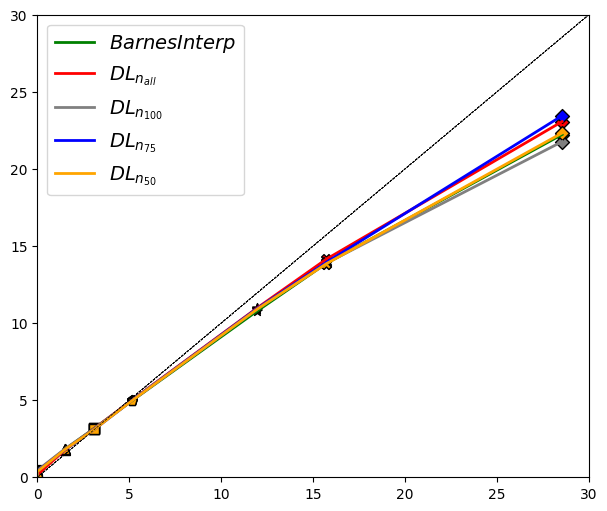

In [ ]:
fontsize = 14
fig = plt.figure(figsize=(17, 5), constrained_layout=True)
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0])
for j,(label,test_data) in enumerate(all_preds.items()):

    # Flatten the data for plotting
    test_1d = test_data.values.flatten()
    target_1d = target_data.flatten()

    # Step 2: Create a mask of valid (non-NaN) values across all
    valid_mask = (
        ~np.isnan(test_1d) &
        ~np.isnan(target_1d)
    )
    # Step 3: Apply the mask to all arrays
    test_clean = test_1d[valid_mask]
    target_clean = target_1d[valid_mask]

    # Compute quantiles for 
    x_quantiles = np.quantile(target_clean, percentiles)
    y_quantiles = np.quantile(test_clean, percentiles)

    line, = ax.plot(x_quantiles, y_quantiles, linestyle='-', color=colors[j], label=fr'${label}$', linewidth=2)

    # Add markers for different percentiles
    for l in range(len(percentiles)):
        marker_point = ax.scatter(x_quantiles[l], y_quantiles[l], facecolors=colors[j], marker=markers[l], s=50, edgecolors='black')

    # Set plot limits
    min_value, max_value =0, 30
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add 1:1 reference line
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', linewidth=0.5)
ax.legend(loc='upper left', fontsize=fontsize)